In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8')
sns.set_palette('husl')

In [2]:
# Try latin1 encoding
df = pd.read_csv(r'..\\data\\sierraleone_bumbuna_qc.csv', encoding='latin1')

print(f'Dataset shape: {df.shape}')
df.head()



Dataset shape: (525601, 19)


,Timestamp,GHI,DNI,DHI,ModA,ModB,Tamb,RH,WS,WSgust,WSstdev,WD,WDstdev,BP,Cleaning,Precipitation,TModA,TModB,Comments
0,yyyy-mm-dd hh:mm,W/m²,W/m²,W/m²,W/m²,W/m²,°C,%,m/s,m/s,m/s,°N (to east),°,hPa,1 or 0,mm/min,°C,°C,NaN
1,2021-10-30 00:01,-0.7,-0.1,-0.8,0,0,21.9,99.1,0,0,0,0,0,1002,0,0,22.3,22.6,NaN
2,2021-10-30 00:02,-0.7,-0.1,-0.8,0,0,21.9,99.2,0,0,0,0,0,1002,0,0,22.3,22.6,NaN
3,2021-10-30 00:03,-0.7,-0.1,-0.8,0,0,21.9,99.2,0,0,0,0,0,1002,0,0,22.3,22.6,NaN
4,2021-10-30 00:04,-0.7,0,-0.8,0,0,21.9,99.3,0,0,0,0,0,1002,0,0.1,22.3,22.6,NaN


In [3]:
numeric_cols = df.select_dtypes(include=[np.number]).columns
df[numeric_cols].describe()

,Comments
count,0.0
mean,NaN
std,NaN
min,NaN
25%,NaN
50%,NaN
75%,NaN
max,NaN


In [4]:
# Missing values report
missing_values = df.isna().sum()
missing_percent = (missing_values / len(df)) * 100
missing_df = pd.DataFrame({'Missing Count': missing_values, 'Missing %': missing_percent})
missing_df = missing_df[missing_df['Missing Count'] > 0].sort_values('Missing %', ascending=False)
print('Missing Values Report:')
print(missing_df)

# Columns with >5% nulls
high_missing_cols = missing_df[missing_df['Missing %'] > 5].index.tolist()
print(f'\nColumns with >5% null values: {high_missing_cols}')


Missing Values Report:
          Missing Count  Missing %
Comments         525601      100.0

Columns with >5% null values: ['Comments']


In [5]:
solar_cols = ['GHI', 'DNI', 'DHI', 'ModA', 'ModB', 'WS', 'WSgust']
z_scores = {}

for col in solar_cols:
    if col in df.columns:
        # Convert to numeric, coerce errors to NaN
        df[col] = pd.to_numeric(df[col], errors='coerce')
        
        # Compute z-score for numeric values only
        z = stats.zscore(df[col], nan_policy='omit')  # NaNs ignored
        df[f'{col}_zscore'] = np.abs(z)  # assign full-length array
        
        # Keep max z-score for reporting
        z_scores[col] = np.nanmax(df[f'{col}_zscore'])

print('Maximum Z-scores for each column:')
for col, max_z in z_scores.items():
    print(f'{col}: {max_z:.2f}')


Maximum Z-scores for each column:
GHI: 4.35
DNI: 3.79
DHI: 4.90
ModA: 4.32
ModB: 4.41
WS: 14.57
WSgust: 13.73


In [6]:
# Flag rows with |Z| > 3 (outliers)
outlier_mask = pd.Series([False] * len(df), index=df.index)
for col in solar_cols:
    if f'{col}_zscore' in df.columns:
        outlier_mask |= (df[f'{col}_zscore'] > 3)

print(f'Total outliers detected: {outlier_mask.sum()} ({outlier_mask.mean()*100:.2f}% of data)')

# Show sample of outliers
if outlier_mask.sum() > 0:
    print('\nSample of outlier rows:')
    outlier_sample = df[outlier_mask].head()
    print(outlier_sample[['GHI', 'DNI', 'DHI', 'ModA', 'ModB', 'WS', 'WSgust']].head())


Total outliers detected: 16292 (3.10% of data)

Sample of outlier rows:
       GHI    DNI    DHI   ModA   ModB   WS  WSgust
654  814.0  257.0  594.3  878.0  856.0  0.5     1.1
655  826.0  263.5  599.6  883.0  861.0  1.7     2.4
656  851.0  285.0  605.9  912.0  890.0  1.6     2.1
657  823.0  254.8  603.9  878.0  856.0  0.8     1.6
658  810.0  244.5  598.8  864.0  843.0  0.6     1.6


In [7]:
# Create a cleaning flag column
df['cleaning_flag'] = outlier_mask.astype(int)

# Drop or impute missing values in key columns
# For numeric columns, impute with median
numeric_cols = df.select_dtypes(include=[np.number]).columns
for col in numeric_cols:
    if df[col].isna().sum() > 0:
        median_val = df[col].median()
        df[col].fillna(median_val, inplace=True)
        print(f'Imputed {df[col].isna().sum()} missing values in {col} with median: {median_val:.2f}')

# For categorical columns, impute with mode
categorical_cols = df.select_dtypes(include=['object']).columns
for col in categorical_cols:
    if df[col].isna().sum() > 0:
        mode_val = df[col].mode()[0] if not df[col].mode().empty else 'Unknown'
        df[col].fillna(mode_val, inplace=True)
        print(f'Imputed {df[col].isna().sum()} missing values in {col} with mode: {mode_val}')


Imputed 0 missing values in GHI with median: 0.30
Imputed 0 missing values in DNI with median: -0.10
Imputed 0 missing values in DHI with median: -0.10
Imputed 0 missing values in ModA with median: 3.60
Imputed 0 missing values in ModB with median: 3.40
Imputed 0 missing values in WS with median: 0.80
Imputed 0 missing values in WSgust with median: 1.60
Imputed 525601 missing values in Comments with median: nan
Imputed 0 missing values in GHI_zscore with median: 0.68
Imputed 0 missing values in DNI_zscore with median: 0.53
Imputed 0 missing values in DHI_zscore with median: 0.74
Imputed 0 missing values in ModA_zscore with median: 0.69
Imputed 0 missing values in ModB_zscore with median: 0.69
Imputed 0 missing values in WS_zscore with median: 0.92
Imputed 0 missing values in WSgust_zscore with median: 0.87


In [9]:
# Export cleaned DataFrame
df.to_csv('..\\data\\sierraleone_bumbuna_qc_clean.csv', index=False)
print('Cleaned data exported to data/benin_clean.csv')
print(f'Cleaned dataset shape: {df.shape}')


Cleaned data exported to data/benin_clean.csv
Cleaned dataset shape: (525601, 27)


Using 'Timestamp' as time index.
Cleaning column: GHI
Cleaning column: DNI
Cleaning column: DHI
Cleaning column: Tamb


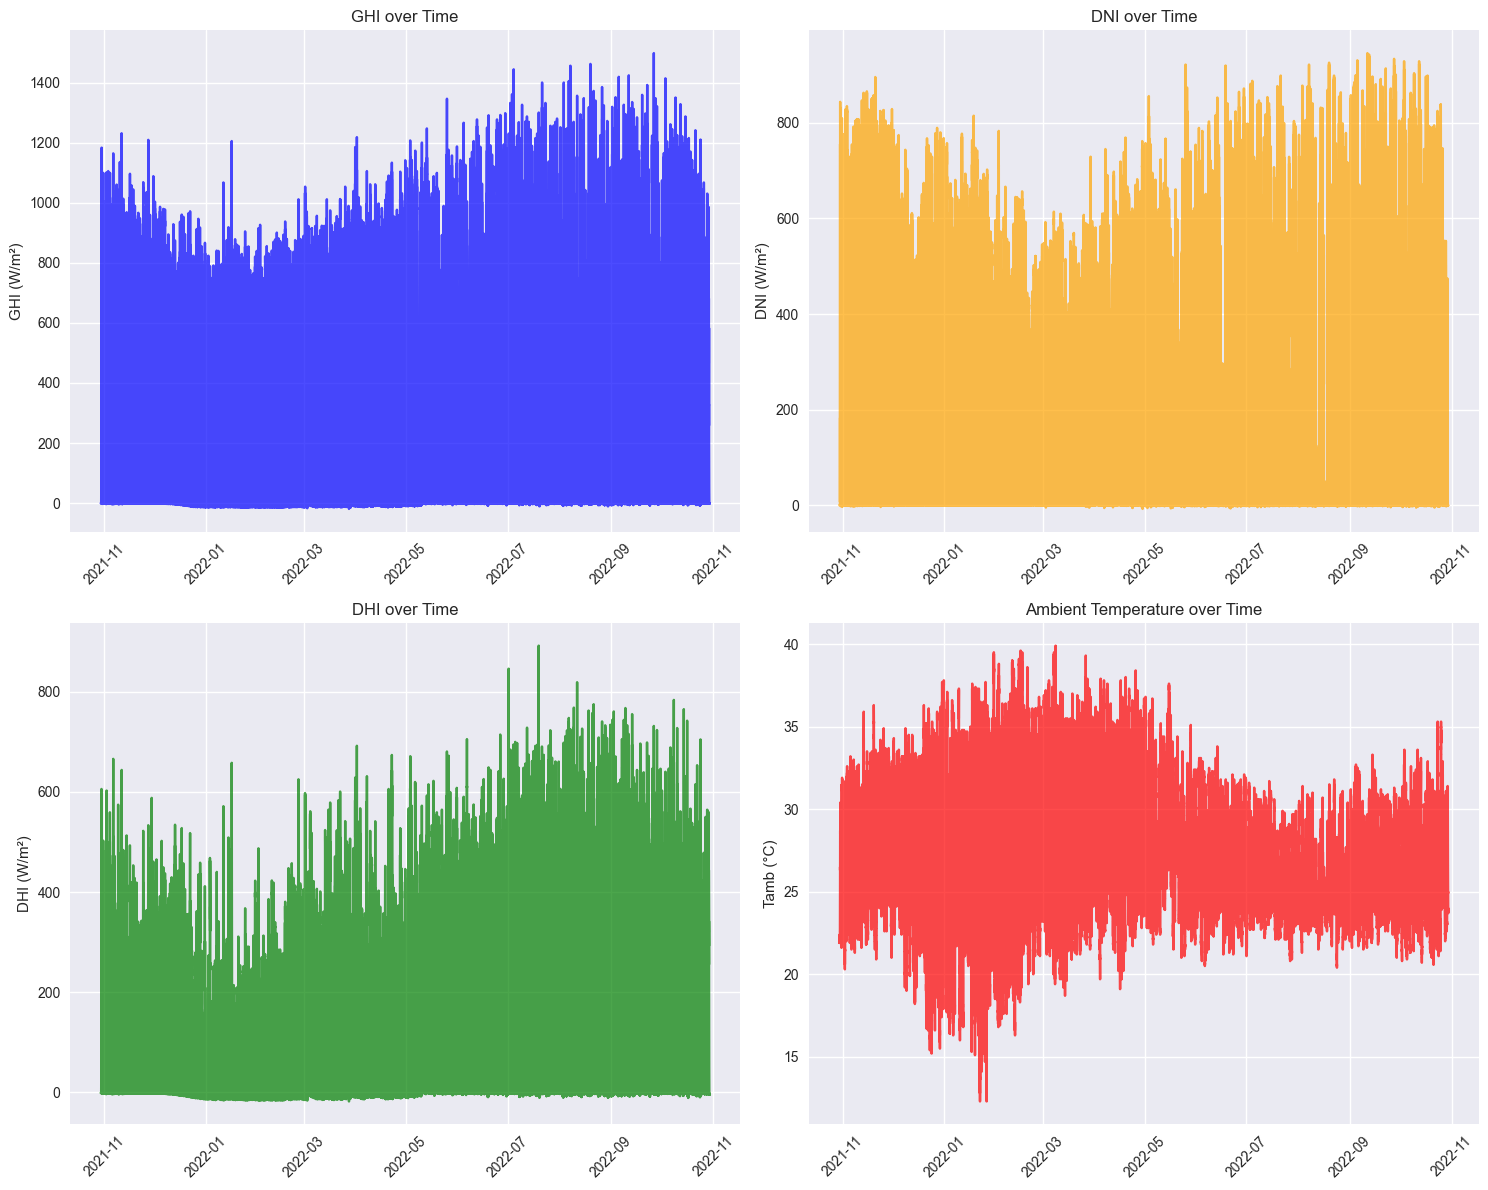

In [10]:
import pandas as pd
import matplotlib.pyplot as plt

# --- Step 1: Safely set timestamp index ---
time_cols = [col for col in df.columns if 'time' in col.lower() or 'date' in col.lower()]

if time_cols:
    timestamp_col = time_cols[0]
    df[timestamp_col] = pd.to_datetime(df[timestamp_col], errors='coerce')
    df = df.dropna(subset=[timestamp_col])  # Remove invalid timestamps
    df.set_index(timestamp_col, inplace=True)
    print(f"Using '{timestamp_col}' as time index.")
else:
    print("No timestamp column found. Using row index.")
    x_data = df.index  # fallback

x_data = df.index

# --- Step 2: Clean numeric columns ---
numeric_cols = ['GHI', 'DNI', 'DHI', 'Tamb']

for col in numeric_cols:
    if col in df.columns:
        print(f"Cleaning column: {col}")
        df[col] = df[col].replace(['N/A', 'NA', '-', '', 'null'], pd.NA)
        df[col] = pd.to_numeric(df[col], errors='coerce')

# Optional: Drop rows where ALL solar values are missing
# df = df.dropna(subset=['GHI', 'DNI', 'DHI'], how='all')

# --- Step 3: Plot ---
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# GHI
if 'GHI' in df.columns:
    axes[0,0].plot(x_data, df['GHI'], alpha=0.7, color='blue')
    axes[0,0].set_title('GHI over Time')
    axes[0,0].set_ylabel('GHI (W/m²)')
    axes[0,0].tick_params(axis='x', rotation=45)

# DNI
if 'DNI' in df.columns:
    axes[0,1].plot(x_data, df['DNI'], alpha=0.7, color='orange')
    axes[0,1].set_title('DNI over Time')
    axes[0,1].set_ylabel('DNI (W/m²)')
    axes[0,1].tick_params(axis='x', rotation=45)

# DHI
if 'DHI' in df.columns:
    axes[1,0].plot(x_data, df['DHI'], alpha=0.7, color='green')
    axes[1,0].set_title('DHI over Time')
    axes[1,0].set_ylabel('DHI (W/m²)')
    axes[1,0].tick_params(axis='x', rotation=45)

# Tamb
if 'Tamb' in df.columns:
    axes[1,1].plot(x_data, df['Tamb'], alpha=0.7, color='red')
    axes[1,1].set_title('Ambient Temperature over Time')
    axes[1,1].set_ylabel('Tamb (°C)')
    axes[1,1].tick_params(axis='x', rotation=45)

# Final layout
plt.tight_layout()
plt.show()